In [22]:
import pandas as pd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model
from sklearn import datasets
import glob
import time

In [23]:
extension = 'npz'
lamb_list = [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
cv_train_filenames=[i for i in glob.glob('./cv_npz/cv_[0-9]_train.{}'.format(extension))]
cv_vali_filenames = [i for i in glob.glob('./cv_npz/cv_[0-9]_vali.{}'.format(extension))]

In [24]:
for i in range(len((cv_train_filenames))):
    i = {'train_{}'.format(i+1) : np.load(cv_train_filenames[i])}

In [25]:
train_dict = {}
for i in range(len(cv_train_filenames)):
    train_dict[i] = np.load(cv_train_filenames[i])
vali_dict = {}
for i in range(len(cv_vali_filenames)):
    vali_dict[i] = np.load(cv_vali_filenames[i])    
test_train = np.load('./cv_npz/test_train.{}'.format(extension))
test_test = np.load('./cv_npz/test_test.{}'.format(extension))

In [26]:
def lasso_train(x, y, alpha=1, lamb=0.1, max_iter=1000, epsilon=1e-6):
    
    # Add a column for intercept coef
    train_x = np.column_stack((np.ones(len(x)), x))

    # Just initialize all coefs to 0
    weights = np.zeros(train_x.shape[1])
    
    # Compute c_1, c_2 (it is same for every j)
    #c_1 = 2 * lamb * (1 - alpha)
    c_2 = lamb * alpha

    # No converge stopping
    for iter in range(max_iter):
        old_weights = weights.copy()

        # Iterate through all coefficients
        for j in range(len(weights)):
            
            # Exclude the contribution of current coefficient
            cur_weights = weights.copy()
            cur_weights[j] = 0
            
            # Compute p_j (1): residuals (without contribution of w_j)
            predict = np.dot(train_x, cur_weights)
            residual = y - predict
            
            # Compute p_j (2): weight residuals by x_j and take sum (dot product)
            p_j = np.dot(train_x[:, j], residual)
            
            # Compute z_j
            z_j = np.sum(train_x[:, j] ** 2)
            
            # Compare p_j with alpha * lambda and update weights
            if p_j < -c_2:
                weights[j] = (p_j + c_2) / (z_j)
            elif p_j > c_2:
                weights[j] = (p_j - c_2) / (z_j)
            else:
                weights[j] = 0
                
        # Need to specially handle the intercept (best intercept)
        best_intercepts = y - np.dot(train_x[:, 1:], weights[1:])
        weights[0] = np.sum(best_intercepts) / (train_x.shape[0])
        
        # If the update is too small, we stop the iteration
        max_update = np.max(np.abs(weights - old_weights))
        if max_update < epsilon:
            # print("Early stop: at iteration {}".format(iter))
            return weights
    
    return weights


def lasso_predict(x, coefs):
    x_padding = np.column_stack((np.ones(len(x)), x))
    y_predict = np.dot(x_padding, coefs)
    return y_predict



In [27]:
start_time = time.time()
error_list = {}
for l in lamb_list:    
    errors = 0
    
    # for each fold of cross validation
    for i in range(len(train_dict)):
        
        #use train set to tune weight
        weight = lasso_train(train_dict[i]['train_x'],train_dict[i]['train_y'],lamb = l)
        
        #use vali set to test accuracy
        # MSE = sum((y-y.pred)**2)/n
        error = np.average((vali_dict[i]['vali_y']-lasso_predict(vali_dict[i]['vali_x'],weight))**2)
        errors = errors+error
    errors = errors/len(train_dict)
    error_list[l] = errors
print("--- %s seconds ---" % (time.time() - start_time))

--- 73.18672800064087 seconds ---


In [28]:
error_list

{1000: 4.456262150975318,
 100: 3.9663641648702623,
 10: 4.079988296343167,
 1: 4.945581685161007,
 0.1: 5.215023540851648,
 0.01: 5.245261678127781,
 0.001: 5.248347403572992,
 0.0001: 5.24866486974524}

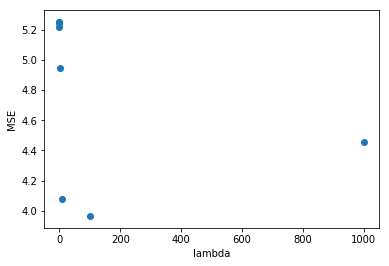

<Figure size 432x288 with 0 Axes>

In [42]:
x = [1000,100,10,1,0.1,0.01,0.001,0.0001]
y = [4.456262150975318,3.9663641648702623,4.079988296343167,4.945581685161007,5.215023540851648,5.245261678127781,5.248347403572992,5.24866486974524]
plt.scatter(x,y)
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.show()
plt.savefig('sample.pdf')

In [29]:
test_weight = lasso_train(test_train['train_x'],test_train['train_y'],lamb = 100)

test_y = test_test['test_y']
test_x = test_test['test_x']
E_test_y = np.average(test_y)
E_test_y_array = np.empty(test_y.shape[0])
E_test_y_array.fill(E_test_y)

SSt = np.sum((test_y - E_test_y_array)**2)
SSr = np.sum((test_y-lasso_predict(test_x,test_weight))**2)
#MSE
MSE = SSr/test_y.shape[0]

#R^2
R_square = 1-SSr/SSt

In [30]:
MSE

2.778384291808951

In [31]:
R_square

0.8636028540905256

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
No handles with labels found to put in legend.


(0.005364445876416993,
 288.8403503791384,
 -2.071737865631385,
 1.9384267369445234)

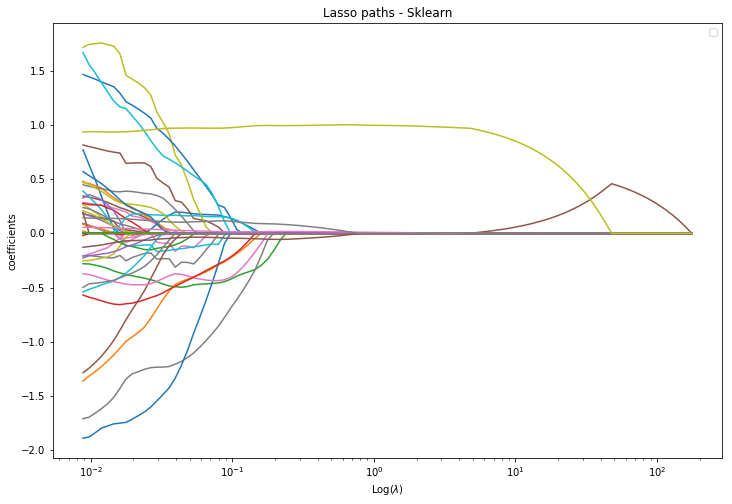

In [34]:
test_x / np.linalg.norm(test_x,axis=0)  # Standardize data (easier to set the l1_ratio parameter)
m,n = test_x.shape

eps = 5e-5  # the smaller it is the longer is the path

alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(test_x, test_y, eps, fit_intercept=False)

# Display results
plt.figure(figsize = (12,8))
#neg_log_alphas_lasso = -np.log10(alphas_lasso)

for i in range(n):
    plt.plot(alphas_lasso, coefs_lasso[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

In [35]:
linear_model.lasso_path(test_x, test_y, eps, fit_intercept=False)

(array([1.76037975e+02, 1.59280135e+02, 1.44117549e+02, 1.30398358e+02,
        1.17985157e+02, 1.06753624e+02, 9.65912706e+01, 8.73963170e+01,
        7.90766721e+01, 7.15490112e+01, 6.47379420e+01, 5.85752488e+01,
        5.29992098e+01, 4.79539788e+01, 4.33890258e+01, 3.92586311e+01,
        3.55214270e+01, 3.21399841e+01, 2.90804357e+01, 2.63121395e+01,
        2.38073696e+01, 2.15410400e+01, 1.94904524e+01, 1.76350694e+01,
        1.59563085e+01, 1.44373564e+01, 1.30630001e+01, 1.18194749e+01,
        1.06943264e+01, 9.67628581e+00, 8.75515704e+00, 7.92171462e+00,
        7.16761130e+00, 6.48529444e+00, 5.86793036e+00, 5.30933591e+00,
        4.80391656e+00, 4.34661034e+00, 3.93283713e+00, 3.55845283e+00,
        3.21970785e+00, 2.91320951e+00, 2.63588811e+00, 2.38496617e+00,
        2.15793061e+00, 1.95250758e+00, 1.76663968e+00, 1.59846538e+00,
        1.44630033e+00, 1.30862056e+00, 1.18404714e+00, 1.07133241e+00,
        9.69347505e-01, 8.77070996e-01, 7.93578699e-01, 7.180344